In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import rotate
import Utils
from Utils import Constants
import cv2
from facenet_pytorch import InceptionResnetV1
from Models import *
from DataLoaders import *

In [3]:
train_labels = pd.read_csv('train_data_clean.csv')
test_labels = pd.read_csv('test_data_clean.csv')
validation_labels = pd.read_csv('validation_data_clean.csv')
train_labels

,name,skin_tone,gender,age,is_face
0,TRAIN0001.png,0,0,1,False
1,TRAIN0002.png,5,1,0,True
2,TRAIN0005.png,1,1,0,False
3,TRAIN0007.png,1,0,1,True
4,TRAIN0009.png,7,0,1,False
...,...,...,...,...,...
6837,TRAIN9992.png,4,0,2,True
6838,TRAIN9993.png,1,1,1,True
6839,TRAIN9995.png,8,0,1,True
6840,TRAIN9998.png,4,1,1,False


(256, 256, 3)


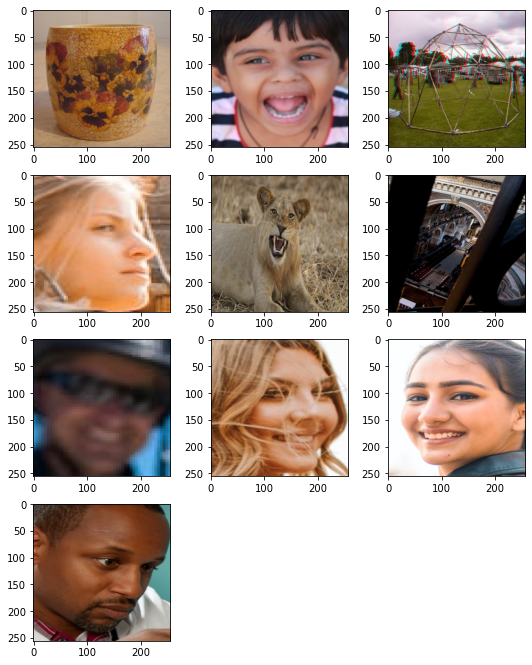

In [4]:
augmentor = Augmentor()
ti = [read_image(n) for n in train_labels.iloc[0:10].name]
print(ti[0].shape)
Utils.plot_selection(ti)

(160, 160, 3) [(0.006617942, 0.8690991), (0.0054422454, 0.99886245), (0.0013034251, 0.9739593), (0.012659867, 0.9965909), (0.008691214, 0.8006778), (0.0, 0.9560954), (0.002581881, 0.60045004), (0.003688087, 0.9986996), (0.02631332, 0.9986768), (0.0008486075, 0.9978207)]


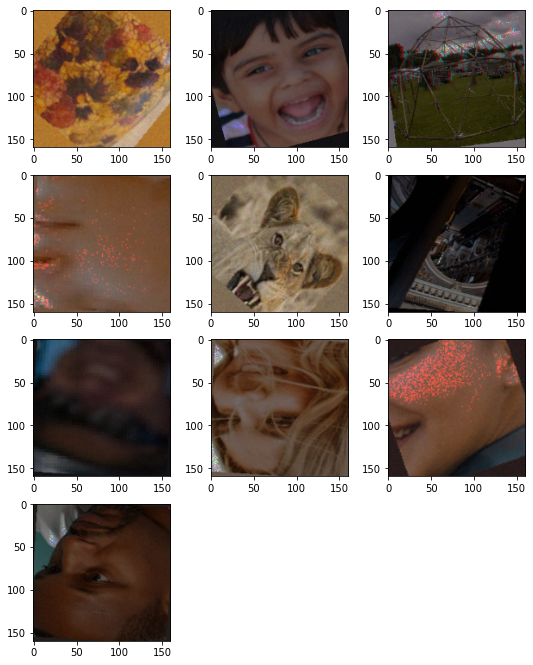

In [5]:
test_images = np.stack(ti)
test_images = augmentor.augment_images(test_images)
print(test_images[0].shape,[(t.min(),t.max()) for t in test_images])
Utils.plot_selection(test_images)
del test_images
del ti
del augmentor

In [6]:
upsample_data(train_labels)

,name,skin_tone,gender,age,is_face
0,TRAIN0002.png,5,1,0,True
1,TRAIN0002.png,5,1,0,True
2,TRAIN0002.png,5,1,0,True
3,TRAIN0002.png,5,1,0,True
4,TRAIN0002.png,5,1,0,True
...,...,...,...,...,...
35349,TRAIN9999.png,3,1,1,True
35350,TRAIN9999.png,3,1,1,True
35351,TRAIN9999.png,3,1,1,True
35352,TRAIN9999.png,3,1,1,True


In [7]:
train_dataset = FaceGenerator(train_labels,Constants.data_root)
val_dataset = FaceGenerator(validation_labels,Constants.data_root,fit_df=train_labels,validation=True)
[batch_x, batch_y] = next(iter(val_dataset))
[batch_x,batch_y[0]]

(35354, 5)
(8971, 5)


[tensor([[[[8.4196e-01, 8.5255e-01, 8.6353e-01,  ..., 1.0000e+00,
            9.9569e-01, 9.9216e-01],
           [8.2863e-01, 8.4239e-01, 8.5373e-01,  ..., 1.0000e+00,
            9.9957e-01, 9.9922e-01],
           [8.2157e-01, 8.3392e-01, 8.4608e-01,  ..., 1.0000e+00,
            9.9961e-01, 9.9608e-01],
           ...,
           [9.8627e-01, 9.9333e-01, 9.8922e-01,  ..., 9.8824e-01,
            9.7235e-01, 9.5294e-01],
           [9.5333e-01, 9.8016e-01, 9.9863e-01,  ..., 1.0000e+00,
            1.0000e+00, 1.0000e+00],
           [9.5686e-01, 9.7098e-01, 9.8490e-01,  ..., 1.0000e+00,
            1.0000e+00, 1.0000e+00]],
 
          [[6.0667e-01, 6.1020e-01, 6.1647e-01,  ..., 7.5686e-01,
            7.5698e-01, 7.5804e-01],
           [5.9333e-01, 6.0004e-01, 6.0667e-01,  ..., 7.6569e-01,
            7.6784e-01, 7.7137e-01],
           [5.7843e-01, 5.8549e-01, 5.9216e-01,  ..., 7.7059e-01,
            7.7490e-01, 7.7843e-01],
           ...,
           [9.2745e-01, 9.5569e-01, 9.

In [8]:
test = BasicCnnEmbedding()
print(test.get_identifier())
print(test(batch_x)[0].shape)
test

/opt/conda/envs/rapids/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


basic_cnn_fs8-16-16-32_fks32-16-8-4_h500_es-256_drop0.01-0.2
torch.Size([256])


BasicCnnEmbedding(
  (init_dropout): Dropout(p=0.01, inplace=False)
  (convs): ModuleList(
    (0): ConvBlock(
      (conv1): Sequential(
        (0): Conv2d(3, 8, kernel_size=(32, 32), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): ConvBlock(
      (conv1): Sequential(
        (0): Conv2d(8, 16, kernel_size=(16, 16), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (2): ConvBlock(
      (conv1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(8, 8), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (3): ConvBlock(
      (conv1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d

In [9]:
test = FacenetModel()
print(test.get_identifier())
print(test(batch_x)[0].shape)
test

facenet_h400_st600_a400_g400_ed3_std2_ad2_gd2


/opt/conda/envs/rapids/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([100, 10])


FacenetModel(
  (base_model): InceptionResnetV1(
    (conv2d_1a): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2a): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2b): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2d_3b): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=Tr

In [10]:
test = FacenetModel(base_model=BasicCnnEmbedding(),base_name=None)
print(test.get_identifier())
print(test(batch_x)[0].shape)
test

basic_cnn_fs8-16-16-32_fks32-16-8-4_h500_es-256_drop0.01-0.2_h400_st600_a400_g400_ed3_std2_ad2_gd2
torch.Size([100, 10])


FacenetModel(
  (base_model): BasicCnnEmbedding(
    (init_dropout): Dropout(p=0.01, inplace=False)
    (convs): ModuleList(
      (0): ConvBlock(
        (conv1): Sequential(
          (0): Conv2d(3, 8, kernel_size=(32, 32), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (1): ConvBlock(
        (conv1): Sequential(
          (0): Conv2d(8, 16, kernel_size=(16, 16), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (2): ConvBlock(
        (conv1): Sequential(
          (0): Conv2d(16, 16, kernel_size=(8, 8), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (3): ConvBlock(
        (conv1): Sequential(
          (0): Conv2d(1

In [ ]:
def categorical_accuracy(ypred,y):
    #y is index, ypred i s one hot like in loss functions
    predicted = torch.argmax(ypred,1).long()
    correct = torch.mean((y.long() == predicted).float())
    return correct

def save_train_history(model,history,root=''):
    model_name = model.get_identifier()
    
    df = pd.DataFrame(history)
    df['model'] = model_name
    string = root + 'results/history_' + model_name + '.csv'
    df.to_csv(string,index=False)
    return df, string

def train_model(model,
                train_df,
                validation_df,
                root,
                epochs=300,
                lr=.01,
                batch_size=100,
                patience = 20,
                loss_weights = [2,1,.5],
                save_path=None,
                upsample=True,
               ):
    if save_path is None:
        save_path = root + 'models/' + model.get_identifier()
    train_loader = FaceGenerator(train_df,Constants.data_root,batch_size=batch_size,upsample=upsample)
    validation_loader = FaceGenerator(validation_df,Constants.data_root,validation=True,batch_size=batch_size,upsample=upsample)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    format_y = lambda y: y.long().to(model.device)
    model = model.to(device)
    def train_epoch():
        running_loss = 0
        running_accuracy = [0,0,0]
        curr_loss = 0
        count = 0
        for i, [x_batch, y_batch] in enumerate(train_loader):
            optimizer.zero_grad()
            xb = x_batch.to(device)
            xb.requires_grad = True
            outputs = model(xb)
            losses = [loss_fn(ypred.float(),format_y(y)) for y,ypred in zip(y_batch,outputs)]
            total_losses = torch.mul(loss_weights[0],losses[0]) + torch.mul(loss_weights[1],losses[1]) + torch.mul(loss_weights[2],losses[2])
            total_losses.backward()
            optimizer.step()
            running_loss += total_losses.item()
            print('curr loss',total_losses.item(), 'step',i,' | ',end='\r')
            count += 1
            with torch.no_grad():
                for i,(y,ypred) in enumerate(zip(y_batch,outputs)):
                    accuracy = categorical_accuracy(ypred.float(),format_y(y))
                    running_accuracy[i] += accuracy.item()
        return running_loss/count, [a/count for a in running_accuracy]
    
    def val_epoch():
        with torch.no_grad():
            running_loss = 0
            running_accuracy = [0,0,0]
            count = 0
            for i, [x_batch, y_batch] in enumerate(validation_loader):
                xb = x_batch.to(device)
                outputs = model(xb)
                losses = [loss_fn(ypred.float(),format_y(y)) for y,ypred in zip(y_batch,outputs)]
                total_losses = torch.mul(loss_weights[0],losses[0]) + torch.mul(loss_weights[1],losses[1]) + torch.mul(loss_weights[2],losses[2])
                running_loss += total_losses.item()
                count += 1
                for i,(y,ypred) in enumerate(zip(y_batch, outputs)):
                    accuracy = categorical_accuracy(ypred.float(),format_y(y))
                    running_accuracy[i] += accuracy.item()
        return running_loss/count, [a/count for a in running_accuracy]
    model.train(True)
    
    best_val_loss = 100000
    steps_since_improvement = 0
    hist = []
    
    for epoch in range(epochs):
        print('epoch',epoch)
        model.train(True)
        avg_loss, avg_acc = train_epoch()
        print('train loss', avg_loss, 'train accuracy', avg_acc)
        model.train(False)
        val_loss, val_acc = val_epoch()
        print('val loss', val_loss, 'val accuracy', val_acc)
        torch.save(model.state_dict(), save_path + '_epoch' + str(epoch))
        if best_val_loss > val_loss:
            torch.save(model,save_path)
            best_val_loss = val_loss
            steps_since_improvement = 0
        else:
            steps_since_improvement += 1
        
        hist_entry = {
            'epoch': epoch,
            'train_loss': avg_loss,
            'train_acc':avg_acc,
            'val_loss':val_loss,
            'val_acc': val_acc,
            'lr': lr,
            'loss_weights': '_'.join([str(l) for l in loss_weights])
        }
        hist.append(hist_entry)
        save_train_history(model,hist,root=root)
        if steps_since_improvement > patience:
            break
    return model,hist

m,h = train_model(
    FacenetModel(fine_tune=True),
    train_labels,
    validation_labels,
    Constants.data_root,
)
del m
h

(35354, 5)
(7786, 5)
epoch 0


In [ ]:
m2,h2 = train_model(
    FacenetModel(base_model = BasicCnnEmbedding(),fine_tune=True),
    train_dataset,
    val_dataset,
    data_root,
)
del m2
h2

In [ ]:
torch.device('cuda')